In [55]:
import pickle
import corner
import matplotlib.pylab as plt
import numpy as np
from koe_mass import koe_mass
from koev1_mass import koev1_mass
import matplotlib
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import matplotlib.colors as mcolors
import matplotlib.cm as cm
%matplotlib inline

In [39]:
#### Read in Pickled MCMC chains ####

pickle_file = "pt_ntmp_20_nwlkrs_1024_lgniter_5.18_V_99735.942696.pkl"
#pickle_file = "temp_t15.pkl"

fin = open(pickle_file)

accept_frac = pickle.load(fin)
#acor = pickle.load(fin)
chain = pickle.load(fin)
lnprob = pickle.load(fin)

fin.close()

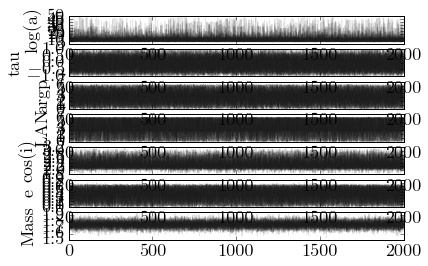

In [40]:
# Plot chains

#convert log(a) to a
chain[:,:,0] = np.exp(chain[:,:,0])
#convert cos(i) to i
chain[:,:,-3] = np.arccos(chain[:,:,-3])

fig = plt.figure()
axlabels = ['log(a)', 'tau', 'argp', 'LAN', 'cos(i)' , 'e', 'Mass']
for i in range(7):
    ax = fig.add_subplot(7,1,i+1)
    ax.plot(chain[::50,:,i].T, 'k-', alpha=0.1)
    ax.set_ylabel(axlabels[i])

In [42]:
### Reshape chains to collapse in walker dimension
lnprob = lnprob.reshape([-1])
chain = chain.reshape([-1,7])



In [5]:
#######  read in measurmeents  #############
filename='Astrometry_csv_fm.csv'

#filename='Astrometry_csv_full_June19.csv' #old measurements from Max's paper

#Read in the input data:
eps=(np.genfromtxt(filename, skip_header=1,delimiter=',', usecols=(9,10), unpack=True))
xy=(np.genfromtxt(filename, skip_header=1,delimiter=',', usecols=(11,13), unpack=True))/1000
sigs=(np.genfromtxt(filename, skip_header=1,delimiter=',', usecols=(12,14), unpack=True))/1000
inst=(np.genfromtxt(filename, skip_header=1,delimiter=',', usecols=(1), dtype='str'))
seps_data=(np.genfromtxt(filename, skip_header=1,delimiter=',', usecols=(3)))/1000
seps_err=(np.genfromtxt(filename, skip_header=1,delimiter=',', usecols=(4)))/1000
pa_data=(np.genfromtxt(filename, skip_header=1,delimiter=',', usecols=(5)))
pa_err=(np.genfromtxt(filename, skip_header=1,delimiter=',', usecols=(6)))

In [43]:
##### compare to best fit orbit #####
bestfit = np.argmax(lnprob)
print(lnprob[bestfit], chain[bestfit])
bestparams = chain[bestfit]


(89.065090190434859, array([ 12.32204452,  -0.84031144,   0.27622438,   6.06308189,
         2.14881555,   0.0918516 ,   1.75308579]))


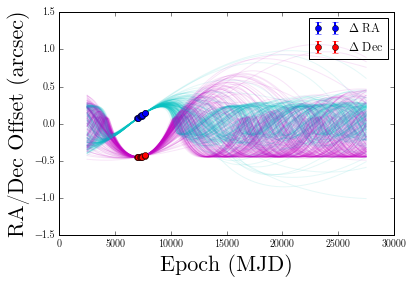

In [7]:
#### Plot RA/Dec offset ####

# plot best fit orbit
epochs_plot = np.linspace(2500,27500,4000)
epochs_plot = np.array([epochs_plot, epochs_plot]).T.ravel()
xy_plot = koe_mass(epochs_plot, bestparams[0], bestparams[1], bestparams[2], bestparams[3], bestparams[4], bestparams[5], bestparams[6])
x_plot = xy_plot[0::2]
y_plot = xy_plot[1::2]
#xy_model_old = koe_mass(epochs_ravel, 9.25, 0.58, np.radians(155.85), np.radians(31.75), np.radians(89.01), 0.07, 1.61)
#also grab some random fits
randfits = np.sort(np.random.randint(0, high=np.size(lnprob), size=200))


fig = plt.figure()
ax = fig.add_subplot(111)
#ax.plot(epochs_plot[0::2], x_plot, 'b-')
#ax.plot(epochs_plot[1::2], y_plot, 'r-')
for rand_fit in randfits:
    randparams = chain[rand_fit]

    xy_plot_rand = koe_mass(epochs_plot, randparams[0], randparams[1], randparams[2], randparams[3], randparams[4], randparams[5], randparams[6])
    x_plot_rand = xy_plot_rand[0::2]
    y_plot_rand = xy_plot_rand[1::2]
    ax.plot(epochs_plot[0::2], x_plot_rand, 'c-', alpha=0.1)
    ax.plot(epochs_plot[1::2], y_plot_rand, 'm-', alpha=0.1)


ax.errorbar(eps[0], xy[0], yerr=sigs[0], fmt='bo', linewidth=2, label=r"$\Delta$ RA")
ax.errorbar(eps[1], xy[1], yerr=sigs[1], fmt='ro', linewidth=2, label=r"$\Delta$ Dec")

ax.set_xlabel("Epoch (MJD)")
ax.set_ylabel("RA/Dec Offset (arcsec)")
ax.legend()
for axis in fig.get_axes():
    for item in ([axis.xaxis.label, axis.yaxis.label]):
        item.set_fontsize(22)


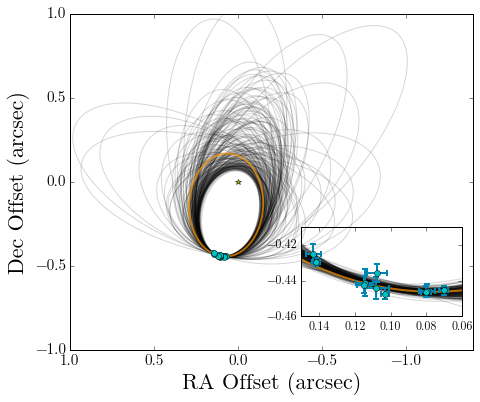

In [49]:
#### Plot sky projection

fig = plt.figure(figsize=(7,7))

ax = fig.add_subplot(111)
inset_ax = inset_axes(ax, width="40%", height="40%", loc=4)

#ax.plot(epochs_plot[0::2], x_plot, 'b-')
#ax.plot(epochs_plot[1::2], y_plot, 'r-')
for rand_fit in randfits:
    randparams = chain[rand_fit]

    rand_period = np.sqrt(randparams[0]**3/randparams[-1]) # years

    epochs_rand = np.linspace(7388,7388+365.26*rand_period,3000)
    epochs_rand = np.array([epochs_rand, epochs_rand]).T.ravel()

    xy_plot_rand = koe_mass(epochs_rand, randparams[0], randparams[1], randparams[2], randparams[3], randparams[4], randparams[5], randparams[6])
    x_plot_rand = xy_plot_rand[0::2]
    y_plot_rand = xy_plot_rand[1::2]
    ax.plot(x_plot_rand, y_plot_rand, '-', alpha=0.16, zorder=-1, c='k')
    inset_ax.plot(x_plot_rand, y_plot_rand, '-', alpha=0.16, zorder=-1, c='k')

ax.plot([0],[0], 'y*')
    
ax.errorbar(xy[0], xy[1], xerr=sigs[0], yerr=sigs[1], fmt='co', linewidth=2, elinewidth=2, capthick=2, ecolor='#0086b3', zorder=1)
inset_ax.errorbar(xy[0], xy[1], xerr=sigs[0], yerr=sigs[1], fmt='co', linewidth=2, elinewidth=2, capthick=2, ecolor='#0086b3', zorder=1)


# most likely
rand_period = np.sqrt(bestparams[0]**3/bestparams[-1]) # years

epochs_rand = np.linspace(7388,7388+365.26*rand_period,3000)
epochs_rand = np.array([epochs_rand, epochs_rand]).T.ravel()
xy_plot_likely = koe_mass(epochs_rand, bestparams[0], bestparams[1], bestparams[2], bestparams[3], bestparams[4], bestparams[5], bestparams[6])
x_plot_likely = xy_plot[0::2]
y_plot_likely = xy_plot[1::2]

ax.plot(x_plot_rand, y_plot_rand, c='#ff9900', alpha=0.7, zorder=0, linewidth=2)
inset_ax.plot(x_plot_rand, y_plot_rand, c='#ff9900', alpha=0.7, zorder=0, linewidth=2)


ax.set_xlabel("RA Offset (arcsec)")
ax.set_ylabel("Dec Offset (arcsec)")
ax.legend()
for axis in fig.get_axes():
    for item in ([axis.xaxis.label, axis.yaxis.label]):
        item.set_fontsize(22)

ax.set_xlim([1.0,-1.4])
ax.set_ylim([-1.,1.])
ax.set_aspect("equal")
ax.tick_params(axis="both", labelsize=15)

inset_ax.set_xlim(0.15,0.06)
inset_ax.yaxis.set_ticks([0.15,0.12,0.09, 0.06])
inset_ax.set_ylim(-0.46,-0.41)
inset_ax.yaxis.set_ticks([-0.46,-0.44,-0.42])
inset_ax.set_aspect("equal")
inset_ax.tick_params(axis="both", labelsize=12)

plt.tight_layout()

plt.savefig("orbit_sky_projection.pdf")

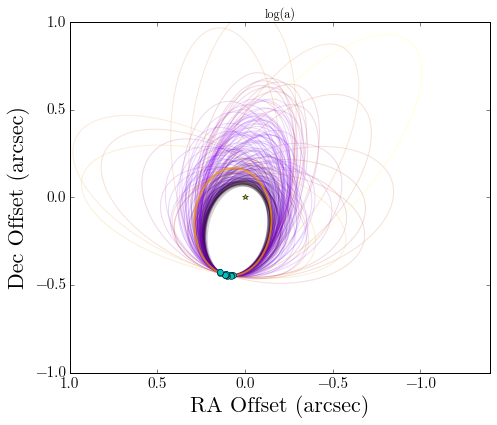

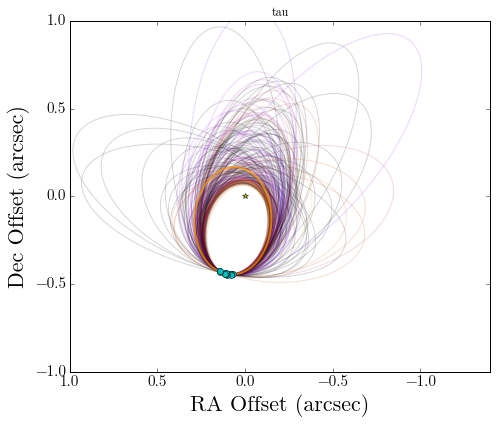

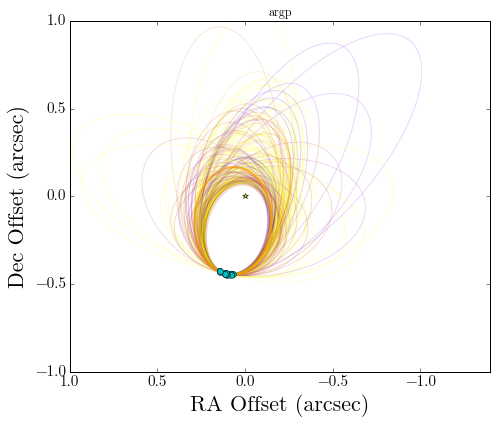

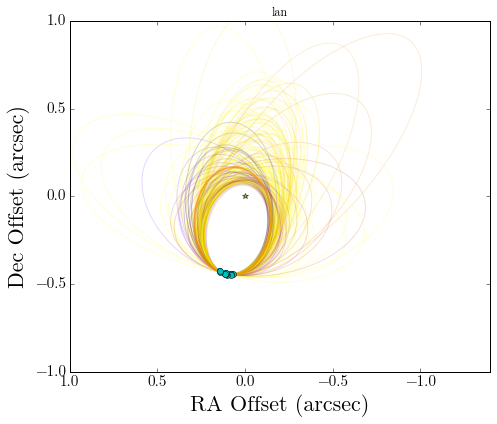

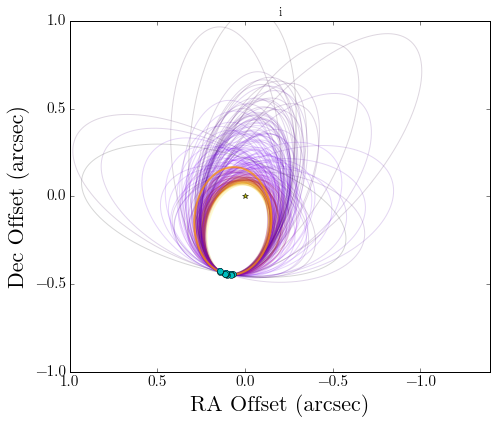

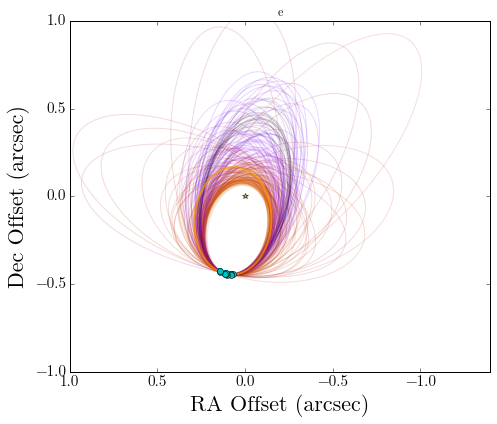

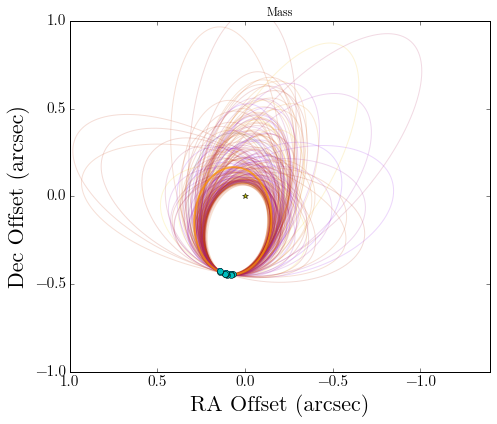

In [59]:
#### Plot sky projection

titles = ['log(a)', 'tau', 'argp', 'lan', 'i', 'e', 'Mass']
for i in range(7):
    min_param = np.min(chain[randfits][:,i])
    max_param = np.max(chain[randfits][:,i])
    
    if i == 2 or i == 3:
        min_param = min_param % (np.pi)
        max_param = max_param % (np.pi)
    elif i == 1 or i == 5:
        min_param = 0
        max_param = 1
        
    colormap = plt.get_cmap('gnuplot')
    cnorm = mcolors.Normalize(vmin=min_param, vmax=max_param)
    scalarmap = cm.ScalarMappable(norm=cnorm, cmap=colormap)
    
    fig = plt.figure(figsize=(7,7))

    ax = fig.add_subplot(111)
#     inset_ax = inset_axes(ax, width="40%", height="40%", loc=4)

    #ax.plot(epochs_plot[0::2], x_plot, 'b-')
    #ax.plot(epochs_plot[1::2], y_plot, 'r-')
    for rand_fit in randfits:
        randparams = chain[rand_fit]

        rand_period = np.sqrt(randparams[0]**3/randparams[-1]) # years

        epochs_rand = np.linspace(7388,7388+365.26*rand_period,3000)
        epochs_rand = np.array([epochs_rand, epochs_rand]).T.ravel()

        xy_plot_rand = koe_mass(epochs_rand, randparams[0], randparams[1], randparams[2], randparams[3], randparams[4], randparams[5], randparams[6])
        x_plot_rand = xy_plot_rand[0::2]
        y_plot_rand = xy_plot_rand[1::2]
        
#         if i == 0 or i == 6:
#             param_norm = (randparams[i] - min_param)/(max_param - min_param)
        if i == 2 or i == 3:
            param_norm = (randparams[i]  % (np.pi) )
        elif i == 1 or i == 5:
            param_norm = randparams[i] % 1
        else:
            param_norm = randparams[i]
        
        thiscolor = scalarmap.to_rgba(randparams[i])[0:3]
        
        ax.plot(x_plot_rand, y_plot_rand, '-', alpha=0.16, zorder=-1, c=thiscolor)
        inset_ax.plot(x_plot_rand, y_plot_rand, '-', alpha=0.16, zorder=-1, c=thiscolor)

    ax.plot([0],[0], 'y*')

    ax.errorbar(xy[0], xy[1], xerr=sigs[0], yerr=sigs[1], fmt='co', linewidth=2, elinewidth=2, capthick=2, ecolor='#0086b3', zorder=1)
#     inset_ax.errorbar(xy[0], xy[1], xerr=sigs[0], yerr=sigs[1], fmt='co', linewidth=2, elinewidth=2, capthick=2, ecolor='#0086b3', zorder=1)


    # most likely
    rand_period = np.sqrt(bestparams[0]**3/bestparams[-1]) # years

    epochs_rand = np.linspace(7388,7388+365.26*rand_period,3000)
    epochs_rand = np.array([epochs_rand, epochs_rand]).T.ravel()
    xy_plot_likely = koe_mass(epochs_rand, bestparams[0], bestparams[1], bestparams[2], bestparams[3], bestparams[4], bestparams[5], bestparams[6])
    x_plot_likely = xy_plot[0::2]
    y_plot_likely = xy_plot[1::2]

    ax.plot(x_plot_rand, y_plot_rand, c='#ff9900', alpha=0.7, zorder=0, linewidth=2)
#     inset_ax.plot(x_plot_rand, y_plot_rand, c='#ff9900', alpha=0.7, zorder=0, linewidth=2)

    ax.set_title(titles[i])
    ax.set_xlabel("RA Offset (arcsec)")
    ax.set_ylabel("Dec Offset (arcsec)")
    ax.legend()
    for axis in fig.get_axes():
        for item in ([axis.xaxis.label, axis.yaxis.label]):
            item.set_fontsize(22)

    ax.set_xlim([1.0,-1.4])
    ax.set_ylim([-1.,1.])
    ax.set_aspect("equal")
    ax.tick_params(axis="both", labelsize=15)

#     inset_ax.set_xlim(0.15,0.06)
#     inset_ax.yaxis.set_ticks([0.15,0.12,0.09, 0.06])
#     inset_ax.set_ylim(-0.46,-0.41)
#     inset_ax.yaxis.set_ticks([-0.46,-0.44,-0.42])
#     inset_ax.set_aspect("equal")
#     inset_ax.tick_params(axis="both", labelsize=12)

    plt.tight_layout()


In [ ]:
#### Separation vs time 

epochs_transit = np.linspace(-7000,7388+365.25*8,10000)
epochs_plot = np.array([epochs_plot, epochs_plot]).T.ravel()
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.plot(epochs_plot[0::2], x_plot, 'b-')
#ax.plot(epochs_plot[1::2], y_plot, 'r-')
for rand_fit in randfits:
    randparams = chain[rand_fit]

    xy_plot_rand = koe_mass(epochs_transit, randparams[0], randparams[1], randparams[2], randparams[3], randparams[4], randparams[5], randparams[6])
    x_plot_rand = xy_plot_rand[0::2]
    y_plot_rand = xy_plot_rand[1::2]
    seps_plot_rand = np.sqrt(x_plot_rand**2 + y_plot_rand**2)
    epochs_transit_year = (epochs_transit - 7388) / 365.25 + 2016
    ax.plot(epochs_transit_year[0::2], seps_plot_rand, 'b-', alpha=0.1)
#ax.axhline(y=0.156/2, linestyle='--', c='k')
#ax.axhline(y=0.246/2, linestyle='--', c='k')

ax.set_xlabel("Year")
ax.set_ylabel("Separation (arcsec)")


# calculate sep and PA for a certain date
specific_date = 7439
seps_date_rand = []
pas_date_rand = []
for rand_fit in randfits:
    randparams = chain[rand_fit]

    xy_date_rand = koe_mass(np.array([specific_date, specific_date]), randparams[0], randparams[1], randparams[2], randparams[3], randparams[4], randparams[5], randparams[6])
    x_date_rand = xy_date_rand[0]
    y_date_rand = xy_date_rand[1]
    sep_rand = np.sqrt(x_date_rand**2 + y_date_rand**2)
    pa_rand =  (np.degrees(np.arctan2(y_date_rand, - x_date_rand)) - 90) % 360
    seps_date_rand.append(sep_rand)
    pas_date_rand.append(pa_rand)

print("For MJD = {0}, sep = {1} +/- {2}, pa = {3} +/- {4}".format(specific_date, np.mean(seps_date_rand), np.std(seps_date_rand), np.mean(pas_date_rand), np.std(pas_date_rand)))


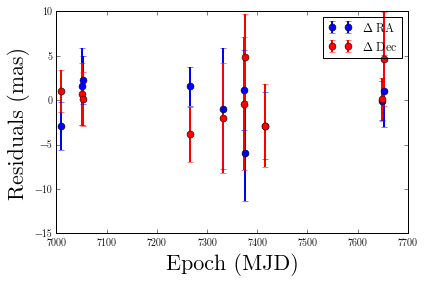

In [32]:
# make residual plot x/y
epochs_ravel = eps.T.ravel()
xy_model = koe_mass(epochs_ravel, bestparams[0], bestparams[1], bestparams[2], bestparams[3], bestparams[4], bestparams[5], bestparams[6])
x_model = xy_model[0::2]
y_model = xy_model[1::2]

#xres = xy[0] - x_model
#yres = xy[1] - y_model

fig = plt.figure()
ax = fig.add_subplot(111)

xres = []
yres = []
for rand_fit in randfits:
    randparams = chain[rand_fit]

    xy_plot_rand = koe_mass(epochs_ravel, randparams[0], randparams[1], randparams[2], randparams[3], randparams[4], randparams[5], randparams[6])
    x_plot_rand = xy_plot_rand[0::2]
    y_plot_rand = xy_plot_rand[1::2]
    xres.append(xy[0] - x_plot_rand)
    yres.append(xy[1] - y_plot_rand)
    #ax.plot(eps[0], xy[0] - x_plot_rand, 'co', alpha=0.1)
    #ax.plot(eps[1], xy[1] - y_plot_rand, 'yo', alpha=0.1)
xres = np.array(xres)
yres = np.array(yres)
xres = np.mean(xres, axis=0)
yres = np.mean(yres, axis=0)

ax.errorbar(eps[0], xres * 1000, yerr=sigs[0]*1000, fmt='bo', linewidth=2, markersize=7, label=r"$\Delta$ RA")
ax.errorbar(eps[1], yres * 1000, yerr=sigs[1]*1000, fmt='ro', linewidth=2, markersize=7, label=r"$\Delta$ Dec")

ax.set_xlabel("Epoch (MJD)")
ax.set_ylabel("Residuals (mas)")
ax.legend()
for axis in fig.get_axes():
    for item in ([axis.xaxis.label, axis.yaxis.label]):
        item.set_fontsize(22)

plt.tight_layout()
plt.savefig("ra_dec_orbit_residuals.pdf")

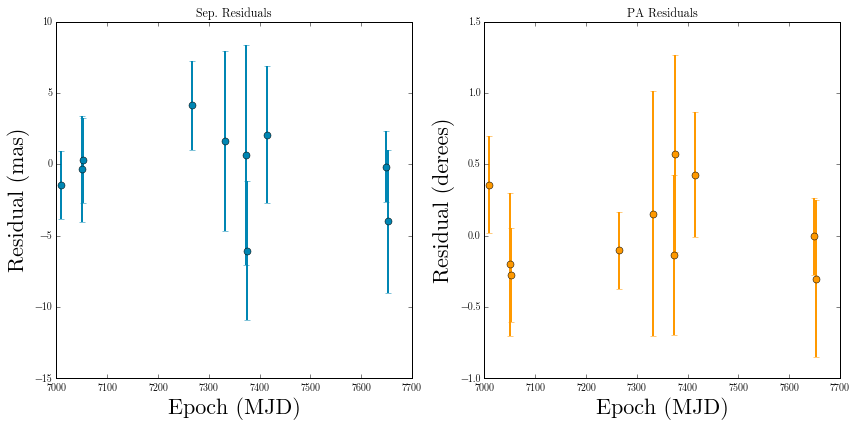

In [34]:
# make residual plot in sep/PA
seps_model = np.sqrt(x_model**2 + y_model**2)
pa_model = (np.degrees(np.arctan2(y_model, -x_model)) - 90) % 360


fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

seps_res = []
pas_res = []
for rand_fit in randfits:
    randparams = chain[rand_fit]


    xy_plot_rand = koe_mass(epochs_ravel, randparams[0], randparams[1], randparams[2], randparams[3], randparams[4], randparams[5], randparams[6])
    x_plot_rand = xy_plot_rand[0::2]
    y_plot_rand = xy_plot_rand[1::2]
    seps_rand = np.sqrt(x_plot_rand**2 + y_plot_rand**2)
    pa_rand = (np.degrees(np.arctan2(y_plot_rand, -x_plot_rand)) - 90 ) % 360

    #ax.plot(eps[0], seps_data - seps_rand, 'mo', alpha=0.1)
    #ax2.plot(eps[1], pa_data - pa_rand, 'co', alpha=0.1)

    seps_res.append(seps_data - seps_rand)
    pas_res.append(pa_data - pa_rand)

seps_res = np.mean(seps_res, axis=0)
pas_res = np.mean(pas_res, axis=0)

ax.errorbar(eps[0], seps_res * 1000, yerr=seps_err * 1000, fmt='o', c="#0086b3", linewidth=2, markersize=7)
ax2.errorbar(eps[1], pas_res, yerr=pa_err, fmt='bo', linewidth=2, c="#ff9900", markersize=7)

ax.set_xlabel("Epoch (MJD)")
ax.set_ylabel("Residual (mas)")
ax.set_title("Sep. Residuals")

ax2.set_xlabel("Epoch (MJD)")
ax2.set_ylabel("Residual (derees)")
ax2.set_title("PA Residuals")
for axis in fig.get_axes():
    for item in ([axis.xaxis.label, axis.yaxis.label]):
        item.set_fontsize(22)

plt.tight_layout()
plt.savefig("sep_pa_orbit_residuals.pdf")

In [35]:
##### calculate Chi^2 #####

chi2_x = ((xy[0] - x_model)/sigs[0])**2 
chi2_y =  ((xy[1] - y_model)/sigs[1])**2 
#chi2_rv = ((rv - koev1_mass(epv,bestparams[0], bestparams[1], bestparams[2], bestparams[3], bestparams[4], bestparams[5], bestparams[6]))/sigv)**2
#print("Reduced Chi2 =  {0}".format(np.sum(chi2_x + chi2_y + chi2_rv)/(2*np.size(chi2_x) + 1 - 7 -1)))
#print("Reduced Chi2 =  {0}".format(np.sum(chi2_x + chi2_y)/(2*np.size(chi2_x)  - 7 -1)))

#random chi2 orbits
randchi2 = []
randchi2_x = []
randchi2_y = []
for rand_fit in randfits:
    randparams = chain[rand_fit]

    xy_model_rand = koe_mass(epochs_ravel, randparams[0], randparams[1], randparams[2], randparams[3], randparams[4], randparams[5], randparams[6])
    x_model_rand = xy_model_rand[0::2]
    y_model_rand = xy_model_rand[1::2]
    chi2_x_rand = ((xy[0] - x_model_rand)/sigs[0])**2
    chi2_y_rand = ((xy[1] - y_model)/sigs[1])**2

    randchi2_x.append(chi2_x_rand)
    randchi2_y.append(chi2_y_rand)

    randchi2.append(np.sum(chi2_x_rand + chi2_y_rand)/(2*np.size(chi2_x_rand) - 7 -1))

print("Mean Reduced Chi2 of 100 random accepted orbits", np.mean(randchi2), np.percentile(randchi2, [16,50,84]))

randchi2_x = np.array(randchi2_x)
randchi2_y = np.array(randchi2_y)

gpidat = np.where(inst == 'GPI')
nongpidat = np.where(inst != 'GPI')

print("Chi2 of GPI x values:", np.mean(randchi2_x[:,gpidat[0]], axis=0))
print("Chi2 of GPI y values:", np.mean(randchi2_y[:,gpidat[0]], axis=0))

print("average Chi2 of GPI x values:", np.mean(randchi2_x[:,gpidat[0]]))
print("average Chi2 of non-GPI x values:", np.mean(randchi2_x[:,nongpidat[0]]))
print("average Chi2 of GPI y values:", np.mean(randchi2_y[:,gpidat[0]]))
print("average Chi2 of non-GPI y values:", np.mean(randchi2_y[:,nongpidat[0]]))

gpi_resx = np.mean(randchi2_x[:,gpidat[0]], axis=0)
gpi_resy = np.mean(randchi2_y[:,gpidat[0]], axis=0)

('Mean Reduced Chi2 of 100 random accepted orbits', 0.80989774852776586, array([ 0.68799432,  0.76565307,  0.91357451]))
('Chi2 of GPI x values:', array([ 1.52107181,  0.24406123,  0.97708996,  0.72354644,  0.04012386,
        0.1188807 ,  1.24256811,  0.64513806,  0.53827166,  0.22136325]))
('Chi2 of GPI y values:', array([  9.80692617e-02,   3.33566110e-02,   1.71033681e-04,
         1.19004426e+00,   6.27670198e-02,   1.69488610e-05,
         1.15619968e+00,   2.86813752e-01,   4.71847354e-02,
         5.72034588e-01]))
('average Chi2 of GPI x values:', 0.62721150903097855)
('average Chi2 of non-GPI x values:', nan)
('average Chi2 of GPI y values:', 0.34466578920234053)
('average Chi2 of non-GPI y values:', nan)


/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


('best-fit orbit', array([  1.23220445e+01,   1.59688557e-01,   1.58264913e+01,
         3.47389003e+02,   1.23118062e+02,   9.18515953e-02,
         1.75308579e+00]))
a = 11.086 (+3.796/-2.550)
tau = 0.424 (+0.256/-0.203)
argp = 178.203 (+120.218/-117.942)
lan = 178.664 (+165.016/-74.078)
i = 129.171 (+20.435/-8.478)
e = 0.469 (+0.193/-0.307)
Mass = 1.750 (+0.050/-0.050)
Period = 27.909 (+15.516/-9.046)


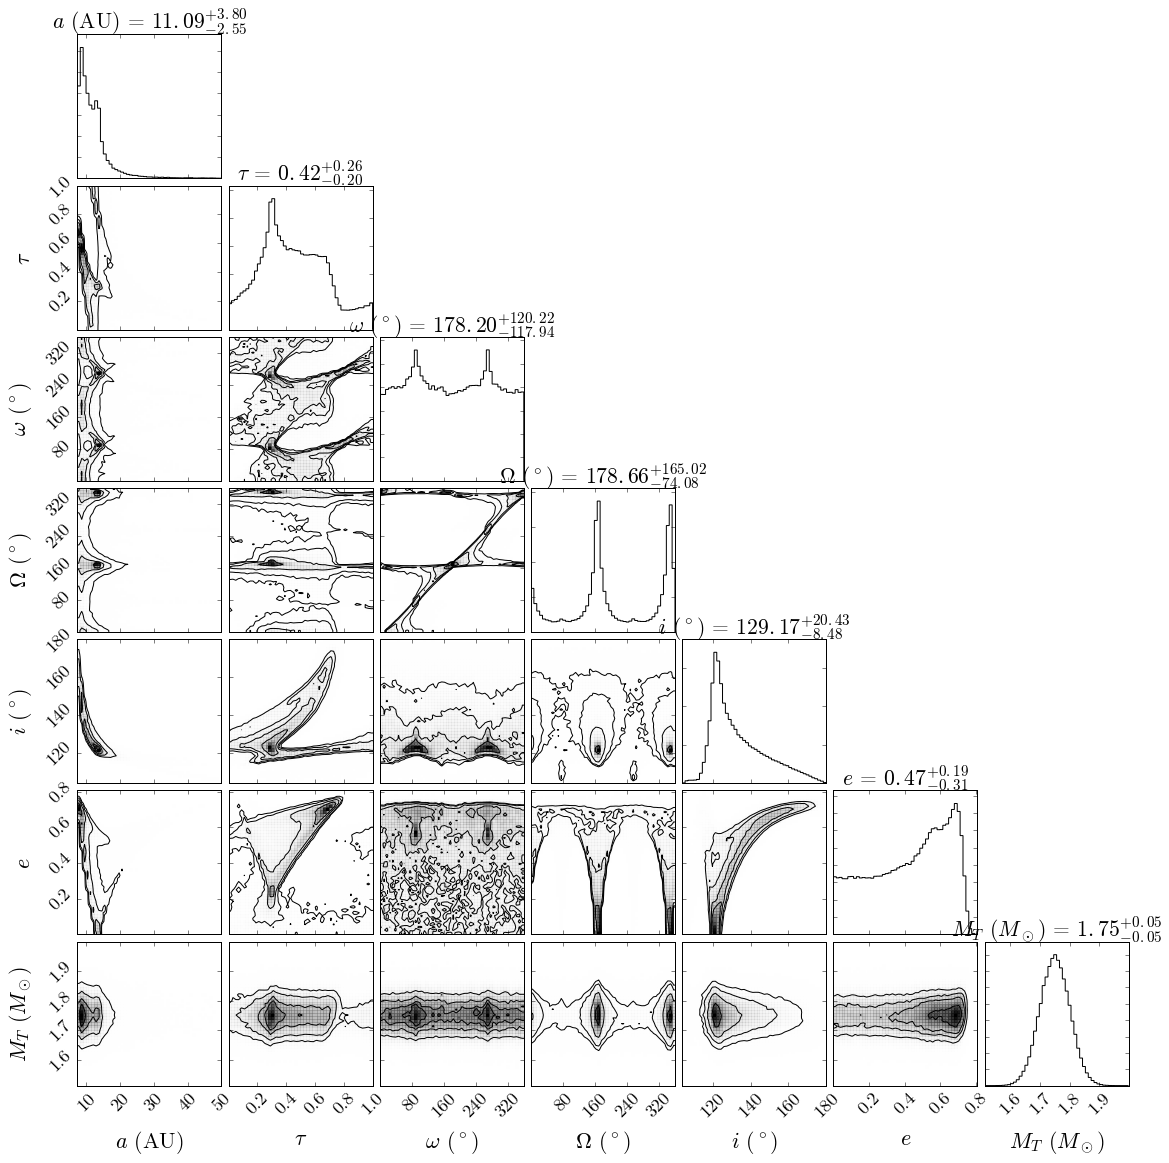

In [44]:

wrapped = np.copy(chain)
##### convert angles to degrees and wrap parameters #####
##### Make more human understandable #####
wrapped[:,2] = np.degrees(chain[:,2]) % 360 # wrap argp
wrapped[:,3] = (np.degrees(chain[:,3]) ) % 360 # wrap LAN 
wrapped[:,4] = np.degrees(chain[:,4])
wrapped[:,1] = (chain[:,1])  % 1.


###### Print ranges on the parameters #####
percentiles = np.array([16,50,84])

params = ['a', 'tau', 'argp', 'lan', 'i', 'e', 'Mass']

print("best-fit orbit", wrapped[bestfit])

for i in range(len(params)):
    param_range = np.percentile(wrapped[:,i], percentiles)
    print("{0} = {1:.3f} (+{3:.3f}/-{2:.3f})".format(params[i], param_range[1], param_range[1]-param_range[0], param_range[2]-param_range[1]))

    
period = np.sqrt(wrapped[:,0]**3/wrapped[:,-1]) # years
param_range = np.percentile(period, percentiles)
print("{0} = {1:.3f} (+{3:.3f}/-{2:.3f})".format("Period", param_range[1], param_range[1]-param_range[0], param_range[2]-param_range[1]))


###### make triangle plot ######
fig = corner.corner(wrapped, labels=[r"$a$ (AU)", r"$\tau$", r"$\omega$ ($^\circ$)", r"$\Omega$ ($^\circ$)", r"$i$ ($^\circ$)", r"$e$", r"$M_T$ ($M_\odot$)"], quantiles=percentiles/100, bins=50, plot_datapoints=False, show_titles=True)#, truths=bestparams)

for axis in fig.get_axes():
    for item in ([axis.xaxis.label, axis.yaxis.label]):
        item.set_fontsize(22)

font = {'size'   : 18}

matplotlib.rc('font', **font)

plt.savefig("51eriorbit_corner.pdf")

